In [3]:
# 读取fashion数据集
def load_fashion_mnist(batchsize,resize=None):
    # resize相当于基本的填充模块
    import torch
    from torch.utils import data
    import torchvision
    from torchvision import transforms

    if resize:
        trans=[transforms.ToTensor()]
        trans.insert(0, transforms.Resize(resize))
        trans = transforms.Compose(trans)
    else:
        trans=transforms.ToTensor()
    train_mnist=torchvision.datasets.FashionMNIST(root='../data/FashionMNIST',train=True,transform=trans,download=True)
    test_mnist=torchvision.datasets.FashionMNIST(root='../data/FashionMNIST',train=False,transform=trans,download=True)
    train_iter=data.DataLoader(train_mnist,batch_size=batchsize,shuffle=True,num_workers=4)
    test_iter=data.DataLoader(test_mnist,batch_size=batchsize,shuffle=True,num_workers=4)
    return train_iter,test_iter
    
batchsize=256
train_iter,test_iter=load_fashion_mnist(batchsize,224)
    

## 网络1:lenet

In [2]:
import torch 
from torch import nn
# LeNet
net=nn.Sequential(
    nn.Conv2d(1,6,kernel_size=5,padding=2),nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2,stride=2),
    nn.Conv2d(6,16,kernel_size=5),nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2,stride=2),
    nn.Flatten(),
    nn.Linear(16*5*5,120),nn.ReLU(),
    nn.Linear(120,84),nn.ReLU(),
    nn.Linear(84,10)
)

## 网络2:Alexnet

In [4]:
import torch 
from torch import nn
#AlexNet
net = nn.Sequential(
    # 这里，我们使用一个11*11的更大窗口来捕捉对象。
    # 同时，步幅为4，以减少输出的高度和宽度。
    # 另外，输出通道的数目远大于LeNet
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 减小卷积窗口，使用填充为2来使得输入与输出的高和宽一致，且增大输出通道数
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 使用三个连续的卷积层和较小的卷积窗口。
    # 除了最后的卷积层，输出通道的数量进一步增加。
    # 在前两个卷积层之后，汇聚层不用于减少输入的高度和宽度
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    # 这里，全连接层的输出数量是LeNet中的好几倍。使用dropout层来减轻过拟合
    nn.Linear(6400, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    # 最后是输出层。由于这里使用Fashion-MNIST，所以用类别数为10，而非论文中的1000
    nn.Linear(4096, 10))

## 网络3 vgg

In [5]:
import torch 
from torch import nn
def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels,
                                kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

def vgg(conv_arch):
    conv_blks = []
    in_channels = 1
    # 卷积层部分
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels

    return nn.Sequential(
        *conv_blks, nn.Flatten(),
        # 全连接层部分
        nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 10))

conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = vgg(small_conv_arch)

# 网络4 resnet

In [4]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


class Residual(nn.Module):  #@save
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 10))

In [2]:
print(net)

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-

training on cuda:0
NVIDIA GeForce RTX 3090
本轮1训练的结果，test—acc:0.8513,train-acc:0.76645,train-loss:0.7906953125
本轮2训练的结果，test—acc:0.8306,train-acc:0.8812833333333333,train-loss:0.31646328125
本轮3训练的结果，test—acc:0.7086,train-acc:0.9046166666666666,train-loss:0.255474072265625
本轮4训练的结果，test—acc:0.8825,train-acc:0.9208166666666666,train-loss:0.21273515625
本轮5训练的结果，test—acc:0.896,train-acc:0.9333166666666667,train-loss:0.18075087890625
本轮6训练的结果，test—acc:0.8903,train-acc:0.9437666666666666,train-loss:0.15271513671875
本轮7训练的结果，test—acc:0.8942,train-acc:0.9535333333333333,train-loss:0.1284052001953125
本轮8训练的结果，test—acc:0.8945,train-acc:0.9625166666666667,train-loss:0.10294580078125
本轮9训练的结果，test—acc:0.8857,train-acc:0.97185,train-loss:0.077942724609375
本轮10训练的结果，test—acc:0.8957,train-acc:0.9803333333333333,train-loss:0.05617334798177084
本轮11训练的结果，test—acc:0.8976,train-acc:0.9865,train-loss:0.041403312174479165
本轮12训练的结果，test—acc:0.8801,train-acc:0.9927833333333334,train-loss:0.023047161865234374


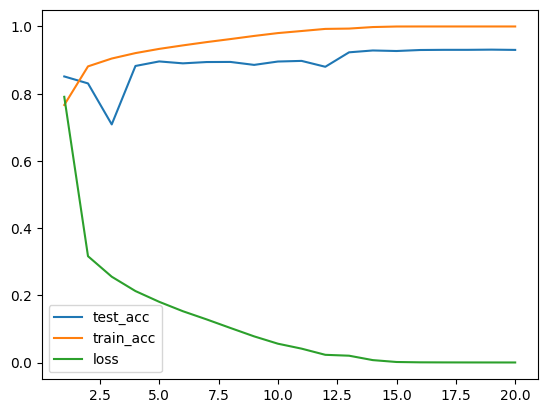

In [5]:
import torch
def accuracy(y_hat,y):
    # 数正确的数量
    if len(y_hat.shape)>1 and y_hat.shape[1]>1:
        y_hat=y_hat.argmax(axis=1)
    cmp=y_hat.type(y.dtype)==y
    return float(cmp.type(y.dtype).sum())

def gpu_acc(model,data_iter,device=None):
    acc=0
    num=0
    if isinstance(net,nn.Module):
        net.eval()
        if not device:
            device=next(iter(net.parameters())).device
    with torch.no_grad():
        for X,y in data_iter:
            if isinstance(X,list):
                # 这里的if仅仅是为之后bert微调所需的
                X=[x.to(device) for x in X]
            else:
                X=X.to(device)
            y=y.to(device)
            acc+=accuracy(net(X),y)
            num+=y.numel()
    return acc/num



def trainer(net,train_iter,test_iter,num_epoches,lr,device):
    '''用GPU训练模型'''
    #初始化参数
    def init_weights(m):
        if type(m)==nn.Linear or type(m)==nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
            #nn.init.normal_(m.weight,std=0.01)
    net.apply(init_weights)

    print('training on',device)
    print(torch.cuda.get_device_name(0))
    net.to(device)
    optimizer=torch.optim.SGD(net.parameters(),lr=lr)
    loss=nn.CrossEntropyLoss()

    train_acc=[]
    test_acc=[]
    loss_epoches=[]
    for epoch in range(num_epoches):
        temp_train_acc=0
        loss_epoch=0
        num=0
        net.train()
        for i,(X,y) in enumerate(train_iter):
            optimizer.zero_grad()
            X,y=X.to(device),y.to(device)
            with torch.no_grad():
                temp_train_acc+=accuracy(net(X),y)
            y_hat=net(X)
            l=loss(y_hat,y)
            l.backward()
            optimizer.step()
            loss_epoch+=l*X.shape[0]
            num+=y.numel()
        train_acc.append(float(temp_train_acc/num))
        test_acc.append(gpu_acc(net,test_iter))
        loss_epoches.append(float(loss_epoch)/num)
        print('本轮{}训练的结果，test—acc:{},train-acc:{},train-loss:{}'.format(str(epoch+1),str(test_acc[-1]),str(train_acc[-1]),str(loss_epoches[-1])))
    import matplotlib.pyplot as plt
    plt.plot(list(range(1,1+num_epoches)),test_acc,label='test_acc')
    plt.plot(list(range(1,1+num_epoches)),train_acc,label='train_acc')
    plt.plot(list(range(1,1+num_epoches)),loss_epoches,label='loss')
    plt.legend()
    plt.show()
    
        
lr,num_epoches=0.2,20


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
trainer(net,train_iter,test_iter,num_epoches,lr,device)